In [ ]:
import os
import pathlib
os.chdir(pathlib.Path("/home/paolo/git/fraud-detection"))
import re
import polars as pl
import mlflow
import pandas as pd
import logging
import shap
import numpy as np
import random
import lightgbm as lgb
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import make_column_transformer
from typing import Callable

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from src.fraud_detection.preprocessing.training import preprocess_data_for_training

In [ ]:
pl.Config(set_fmt_float="full")
pd.options.display.float_format = '{:.3f}'.format
# pd.options.plotting.backend = "matplotlib"

mlflow.set_tracking_uri("./mlflow_runs")

## Disable logging warnings
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.disabled = True
    logger.propagate = False

In [ ]:
SEED = 42
LOG_MODEL = False

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

def show_correlation(correlation: pd.DataFrame, vmin: int = -1, vmax: int = 1) -> None:
    # Compute the correlation matrix
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation, mask=mask, vmin=vmin, vmax=vmax, annot=False, cmap=cmap, ax=ax)

def show_correlation_with_target(correlation: pd.DataFrame, target_col: str) -> None:
    plt.figure(figsize=(20, 20))
    heatmap = sns.heatmap(correlation[[target_col]].sort_values(by=target_col, ascending=False).drop(index=target_col), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=10)

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.metrics import average_precision_score, roc_auc_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, \
    RocCurveDisplay, confusion_matrix, brier_score_loss
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV


def set_seed(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)

def retrieve_categorical_columns_to_encode(dataframe: pd.DataFrame) -> tuple[list[str], list[str]]:
    one_hot_encoded_columns: list[str] = []
    ordinal_encoded_columns: list[str] = []

    for col in dataframe.select_dtypes("category").columns:
        if dataframe[col].nunique() <= 5:
            one_hot_encoded_columns.append(col)
        else:
            ordinal_encoded_columns.append(col)

    return one_hot_encoded_columns, ordinal_encoded_columns

def store_metrics(y_valid: pd.Series, y_pred: pd.Series, y_pred_proba: pd.Series, valid_sample_weight: np.ndarray) -> dict[str, float]:
    fig = ConfusionMatrixDisplay.from_predictions(y_true=y_valid, y_pred=y_pred, normalize="all", sample_weight=valid_sample_weight)
    mlflow.log_figure(fig.figure_, artifact_file="confusion_matrix.png")

    fig = PrecisionRecallDisplay.from_predictions(y_true=y_valid, y_pred=y_pred_proba, sample_weight=valid_sample_weight)
    mlflow.log_figure(fig.figure_, artifact_file="precision_recall_curve.png")

    fig = RocCurveDisplay.from_predictions(y_true=y_valid, y_pred=y_pred_proba, sample_weight=valid_sample_weight)
    mlflow.log_figure(fig.figure_, artifact_file="roc_curve.png")

    fig = CalibrationDisplay.from_predictions(y_true=y_valid, y_prob=y_pred_proba, n_bins=10)
    mlflow.log_figure(fig.figure_, artifact_file="calibration_curve.png")

    conf_matrix: np.ndarray = confusion_matrix(y_pred=y_pred, y_true=y_valid, labels=[0,1], sample_weight=valid_sample_weight)
    tn, fp, fn, tp = conf_matrix.ravel()

    epsilon = 1e-15

    # Calculate metrics
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    balanced_accuracy = (recall + specificity) / 2
    f1 = (2 * precision * recall) / (precision + recall + epsilon)
    false_positive_rate = fp / (fp + tn + epsilon)
    false_negative_rate = fn / (fn + tp + epsilon)
    mcc = (tp * tn - fp * fn) / (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5 + epsilon)
    fowlkes_mallows_index = tp / (((tp + fp) * (tp + fn)) ** 0.5 + epsilon)
    roc_auc = roc_auc_score(y_true=y_valid, y_score=y_pred_proba, sample_weight=valid_sample_weight, average="weighted")
    average_precision = average_precision_score(y_true=y_valid, y_score=y_pred_proba, sample_weight=valid_sample_weight, average="weighted")
    brier_loss = brier_score_loss(y_true=y_valid, y_prob=y_pred_proba, sample_weight=valid_sample_weight)

    metrics = {
        "accuracy": round(accuracy, 3),
        "balanced_accuracy": round(balanced_accuracy, 3),
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "specificity": round(specificity, 3),
        "f1": round(f1, 3),
        "false_positive_rate": round(false_positive_rate, 3),
        "false_negative_rate": round(false_negative_rate, 3),
        "average_precision": round(average_precision, 3),
        "mcc": round(mcc, 3),
        "fowlkes_mallows_index": round(fowlkes_mallows_index, 3),
        "auc": round(roc_auc, 3),
        "brier_loss": round(brier_loss, 3)
    }

    mlflow.log_metrics(metrics)

    return metrics

def compute_feature_importances(pipeline, X_train, X_valid) -> pd.DataFrame:
    shap_values = shap.LinearExplainer(pipeline["model"], X_train, nsamples=100_000, seed=SEED).shap_values(X_valid)

    feature_importances: pd.DataFrame = pd.DataFrame(data={"column": list(X_valid.columns), "importance": np.mean(shap_values, axis=0)}).sort_values(by="importance", ascending=True)
    mlflow.log_table(feature_importances, "feature_importances.json")

    # fig = px.histogram(feature_importances, x="importance", y="column", orientation="h", width=1500, height=1500)
    # mlflow.log_figure(fig, artifact_file="feature_importances.png")

    return feature_importances

def compute_threshold(X: pd.DataFrame, y: np.ndarray, model: BaseEstimator, sample_weight: np.ndarray) -> tuple[float, float]:
    thresholds: np.ndarray = np.arange(start=0.05, stop=1.05, step=0.05)
    output: np.ndarray = np.vectorize(lambda x: f1_score(y_true=y, y_pred=model.predict_proba(X)[:, 1] > x, sample_weight=sample_weight))(thresholds)
    max_index: int = np.argmax(output)

    return float(thresholds[max_index]), float(output[max_index])

def train_valid_test_split(X: pd.DataFrame, y: pd.Series | np.ndarray, valid_size: float = 0.1, test_size: float = 0.1, seed: int = 42):
    if test_size + valid_size > 1.:
        raise ValueError(f"validation and test size must be less than 1.0")

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=seed, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size/X_train.shape[0], random_state=seed, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

def get_learning_curves(model: lgb.LGBMModel, metric: str = "binary_logloss") -> go.Figure:
    keys = list(model.evals_result_.keys())
    train_key, valid_key = "", ""
    for key in keys:
        if "train" in key:
            train_key = key
        elif "valid" in key:
            valid_key = key

    results = pd.DataFrame({"train": model.evals_result_[train_key][metric], "valid": model.evals_result_[valid_key][metric]})

    fig = go.Figure()
    for col in results.columns:
        fig.add_trace(go.Scatter(x=results.index+1, y=results[col], mode='lines', name=f"{col}"))

    fig.update_layout(title=f'Learning curves {metric}',
                      xaxis_title='Iteration',
                      yaxis_title=metric,
                      margin=dict(l=0,r=0,b=0,t=30),
                      )
    return fig

In [ ]:
def define_pipeline(model: BaseEstimator, X: pd.DataFrame, scale_features: bool = True, use_one_hot_encoding: bool = True, use_ordinal_encoding: bool = True) -> Pipeline | BaseEstimator:
    standardized_columns: list[str] = X.select_dtypes(include="number").columns.tolist()
    one_hot_encoded_columns, ordinal_encoded_columns = retrieve_categorical_columns_to_encode(X)

    transforms = []
    if use_one_hot_encoding and one_hot_encoded_columns:
        transforms.append((OneHotEncoder(dtype=np.float32, sparse_output=False, drop="first", handle_unknown="ignore"), one_hot_encoded_columns))
    if use_ordinal_encoding and ordinal_encoded_columns:
        transforms.append((OrdinalEncoder(dtype=np.float32, unknown_value=-1, handle_unknown="use_encoded_value"), ordinal_encoded_columns))
    if scale_features and standardized_columns:
        transforms.append((RobustScaler(), standardized_columns))

    if not transforms:
        return model
    
    column_transformer = make_column_transformer(
        *transforms,
        remainder="passthrough",
        n_jobs=-1,
        verbose=1,
        verbose_feature_names_out=False
    ).set_output(transform="pandas")


    return Pipeline(
        steps=[
            ("column_transformer", column_transformer),
            ("model", model)
        ]
    )

def predict_and_compute_threshold(model: Pipeline, X: pd.DataFrame, y: pd.Series | np.ndarray, sample_weight: np.ndarray) -> tuple[np.ndarray, np.ndarray, float]:
    y_pred_proba = model.predict_proba(X)[:, 1]
    threshold, _ = compute_threshold(X=X, y=y, model=model, sample_weight=sample_weight)
    y_pred = y_pred_proba > threshold
    mlflow.log_metric("threshold", threshold)
    return y_pred_proba, y_pred, threshold

def calibrate_model(model: Pipeline, X: pd.DataFrame, y: pd.Series | np.ndarray, sample_weight: np.ndarray) -> CalibratedClassifierCV:
    original_y_pred_proba = model.predict_proba(X)[:, 1]
    fig = CalibrationDisplay.from_predictions(y_true=y, y_prob=original_y_pred_proba, n_bins=10, name="original calibration curve")
    mlflow.log_figure(fig.figure_, artifact_file="original_calibration_curve.png")
    
    threshold, _ = compute_threshold(X=X, y=y, model=model, sample_weight=sample_weight)
    mlflow.log_metrics({"threshold_uncalibrated": threshold, "brier_score_uncalibrated": round(brier_score_loss(y_true=y, y_prob=original_y_pred_proba, sample_weight=sample_weight), 3)})

    calibrated_classifier: CalibratedClassifierCV = CalibratedClassifierCV(model, cv="prefit", method="isotonic", n_jobs=-1)
    calibrated_classifier.fit(X, y, sample_weight=sample_weight)
    return calibrated_classifier

def train_logistic_regression_model(X: pd.DataFrame, y: pd.Series | np.ndarray) -> tuple[BaseEstimator, pd.DataFrame, dict[str, float]]:
    mlflow.sklearn.autolog(
        log_input_examples=False,
        log_model_signatures=True,
        log_models=False,
        log_datasets=False,
        disable=False,
        exclusive=False,
        disable_for_unsupported_versions=False,
        silent=False,
        registered_model_name=None,
        extra_tags=None
    )
    
    
    pipeline = define_pipeline(
        model=LogisticRegression(random_state=SEED, verbose=0, n_jobs=-1, warm_start=False),
        X=X,
        scale_features=True,
        use_one_hot_encoding=True,
        use_ordinal_encoding=True
    )
    
    X_train, X_valid, y_train, y_valid = train_test_split(X.copy(deep=True), np.copy(y), test_size=0.2, random_state=SEED, stratify=y)
    train_sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    valid_sample_weights = compute_sample_weight(class_weight="balanced", y=y_valid)

    with mlflow.start_run(nested=True, run_name=f"Logistic Regression model", log_system_metrics=True, description="Logistic Regression model"):
        mlflow.log_params({"columns": list(X.columns), "num_columns": len(X.columns)})
        pipeline.fit(X_train, y_train, model__sample_weight=train_sample_weights)

        y_pred_proba, y_pred, threshold = predict_and_compute_threshold(
            model=pipeline,
            X=X_valid,
            y=y_valid,
            sample_weight=valid_sample_weights
        )

        if LOG_MODEL:
            print(f"Logging model")
            mlflow.sklearn.log_model(
                pipeline,
                artifact_path="model",
                registered_model_name="model",
                pyfunc_predict_fn="predict_proba",
                signature=mlflow.models.infer_signature(model_input=X_valid, model_output=y_pred_proba)
            )

        feature_importances: pd.DataFrame = compute_feature_importances(pipeline=pipeline, X_train=pipeline["column_transformer"].transform(X_train), X_valid=pipeline["column_transformer"].transform(X_valid))

        metrics: dict[str, float] = store_metrics(y_valid=y_valid, y_pred=y_pred, y_pred_proba=y_pred_proba, valid_sample_weight=valid_sample_weights)
    return pipeline, feature_importances, metrics

def train_random_random_forest(X: pd.DataFrame, y: pd.DataFrame) -> tuple[BaseEstimator, pd.DataFrame, dict[str, float]]:
    mlflow.sklearn.autolog(
        log_input_examples=False,
        log_model_signatures=True,
        log_models=False,
        log_datasets=False,
        disable=False,
        exclusive=False,
        disable_for_unsupported_versions=False,
        silent=False,
        registered_model_name=None,
        extra_tags=None
    )
    
    pipeline = define_pipeline(
        model=RandomForestClassifier(random_state=SEED, n_jobs=-1, verbose=0, warm_start=False),
        X=X,
        scale_features=False,
        use_one_hot_encoding=True,
        use_ordinal_encoding=True
    )

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    train_sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    valid_sample_weights = compute_sample_weight(class_weight="balanced", y=y_valid)

    with mlflow.start_run(nested=True, run_name=f"Random Forest model", log_system_metrics=True, description="Random forest model"):
        mlflow.log_params({"columns": list(X.columns), "num_columns": len(X.columns)})
        pipeline.fit(X_train, y_train, model__sample_weight=train_sample_weights)

        calibrated_classifier = calibrate_model(
            model=pipeline,
            X=X_valid,
            y=y_valid,
            sample_weight=valid_sample_weights
        )

        y_pred_proba, y_pred, threshold = predict_and_compute_threshold(
            model=calibrated_classifier,
            X=X_valid,
            y=y_valid,
            sample_weight=valid_sample_weights
        )

        if LOG_MODEL:
            print(f"Logging model")
            mlflow.sklearn.log_model(
                calibrated_classifier,
                artifact_path="model",
                registered_model_name="model",
                pyfunc_predict_fn="predict_proba",
                signature=mlflow.models.infer_signature(model_input=X_valid, model_output=y_pred_proba)
            )

        feature_importances: pd.DataFrame = pd.DataFrame(data={"column": pipeline["model"].feature_names_in_, "importance": pipeline["model"].feature_importances_}).sort_values(by="importance", ascending=False)
        feature_importances["importance"] = feature_importances["importance"].astype(np.float32)
        mlflow.log_table(feature_importances, "feat_importances.json")

        metrics: dict[str, float] = store_metrics(y_valid=y_valid, y_pred=y_pred, y_pred_proba=y_pred_proba, valid_sample_weight=valid_sample_weights)
    return calibrated_classifier, feature_importances, metrics

def train_lightgbm(X: pd.DataFrame, y: pd.Series | np.ndarray) -> tuple[BaseEstimator, pd.DataFrame, dict[str, float]]:
    mlflow.lightgbm.autolog(
        log_input_examples=False,
        log_model_signatures=True,
        log_models=False,
        log_datasets=False,
        disable=False,
        exclusive=False,
        disable_for_unsupported_versions=False,
        silent=False,
        registered_model_name=None,
        extra_tags=None
    )
    
    model = lgb.LGBMClassifier(
        random_state=SEED,
        n_jobs=-1,
        boosting_type='gbdt',
        num_leaves=128,
        max_depth=8,
        learning_rate=0.1,
        n_estimators=1_000,
        subsample_for_bin=200_000,
        objective="binary",
        class_weight=None,
        min_split_gain=0.0,
        min_child_weight=0.001,
        min_child_samples=20, # min_data_in_leaf
        subsample=1.,
        subsample_freq=0,
        colsample_bytree=1.,
        # reg_alpha=10.0,
        # reg_lambda=10.0,
        importance_type='gain',
        device="cpu",
        deterministic=True,
        verbose=-1,
        # extra_trees=True,
        # extra_seed=SEED
    )

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    train_sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    valid_sample_weights = compute_sample_weight(class_weight="balanced", y=y_valid)

    with mlflow.start_run(nested=True, run_name=f"Lightgbm model", log_system_metrics=True, description="Lightgbm model"):
        mlflow.log_params({"columns": list(X.columns), "num_columns": len(X.columns)})
        eval_results = {}
        model.fit(
            X=X_train,
            y=y_train,
            sample_weight=train_sample_weights,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_metric=["binary_logloss", "average_precision", "auc"],
            eval_sample_weight=[train_sample_weights, valid_sample_weights],
            # eval_init_score=[train_init_score, valid_init_score],
            callbacks=[
                # lgb.log_evaluation(),
                lgb.record_evaluation(eval_results),
                lgb.early_stopping(stopping_rounds=100, first_metric_only=True),
            ],
        )

        calibrated_classifier = calibrate_model(
            model=model,
            X=X_valid,
            y=y_valid,
            sample_weight=valid_sample_weights
        )

        y_pred_proba, y_pred, threshold = predict_and_compute_threshold(
            model=calibrated_classifier,
            X=X_valid,
            y=y_valid,
            sample_weight=valid_sample_weights
        )

        if LOG_MODEL:
            print(f"Logging model")
            mlflow.sklearn.log_model(
                calibrated_classifier,
                artifact_path="model",
                registered_model_name="model",
                pyfunc_predict_fn="predict_proba",
                signature=mlflow.models.infer_signature(model_input=X_valid, model_output=y_pred_proba)
            )

        feature_importances: pd.DataFrame = pd.DataFrame(data={"column": model.feature_name_, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False)
        feature_importances["importance"] = feature_importances["importance"].astype(np.float32)

        metrics: dict[str, float] = store_metrics(y_valid=y_valid, y_pred=y_pred, y_pred_proba=y_pred_proba, valid_sample_weight=valid_sample_weights)
    return calibrated_classifier, feature_importances, metrics

def train_iterative_model(X: pd.DataFrame, y: np.ndarray, train_model_fn: Callable, run_name: str):
    global LOG_MODEL
    cols_to_drop = []
    try:
        with mlflow.start_run(nested=False, run_name=run_name):
            while True:
                X_transformed: pd.DataFrame = X.copy(deep=True).drop(columns=cols_to_drop)
                model, feature_importances, metrics = train_model_fn(X=X_transformed, y=y)
    
                try:
                    noise_importance: float = feature_importances.query("column == 'noise'").importance.item()
    
                    new_cols_to_drop = feature_importances[
                        (feature_importances.column != "noise") & ((feature_importances.importance <= 1e-4) | (feature_importances.importance <= noise_importance))
                        ].column.tolist()
    
                    new_cols_to_drop = list(set(new_cols_to_drop).intersection(list(X.columns)))
                except ValueError as e:
                    new_cols_to_drop = []
    
                if "noise" in cols_to_drop:
                    print(f"Stopping")
                    break
                elif not new_cols_to_drop:
                    print(f"no new columns to drop. Final training step without the noise column")
                    cols_to_drop.append("noise")
                    LOG_MODEL = True
                else:
                    cols_to_drop.extend(new_cols_to_drop)
    except Exception as e:
        LOG_MODEL = False
    finally:
        LOG_MODEL = False

In [ ]:
set_seed(SEED)
TARGET_COLUMN: str = "isFraud"
data: pl.LazyFrame = preprocess_data_for_training().drop_nulls().drop("TransactionID").with_columns(
    [pl.col(col).str.replace_all(pattern=":", value="_").cast(pl.Categorical).alias(col) for col in ["id_23", "id_34"]]
)
X: pd.DataFrame = data.drop([TARGET_COLUMN, "C2", "C11", "C13", "C14"]).collect().to_pandas()
X["noise"] = np.random.normal(size=X.shape[0])

y: np.ndarray = data.select(TARGET_COLUMN).collect().to_numpy().ravel()

In [ ]:
mlflow.set_experiment(experiment_name="fraud-detection")

In [ ]:
# try:
#     train_iterative_model(X=X, y=y, train_model_fn=train_logistic_regression_model, run_name="Logistic Regression")
# except ValueError as e:
#     LOG_MODEL = False
#     print(e)

2024/03/14 10:57:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/03/14 10:57:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/03/14 10:57:55 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/14 10:57:55 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/14 10:57:55 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/03/14 10:57:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/03/14 10:58:13 INFO mlflow.system_metrics.system_metrics_monitor: St

no new columns to drop. Final training step without the noise column
Logging model


Registered model 'model' already exists. Creating a new version of this model...
Created version '11' of model 'model'.
2024/03/14 11:03:02 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/14 11:03:02 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Stopping


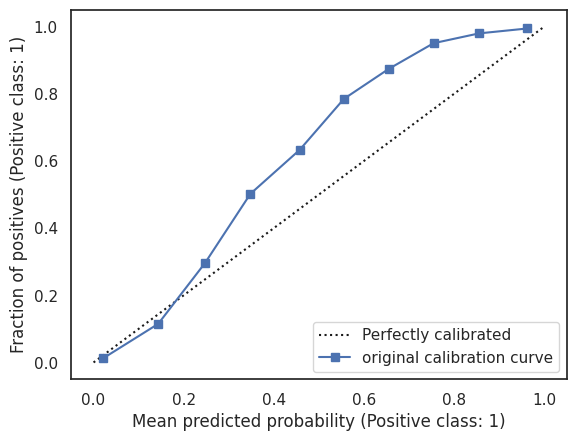

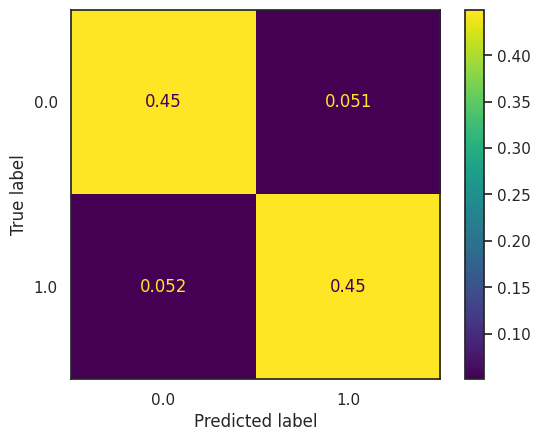

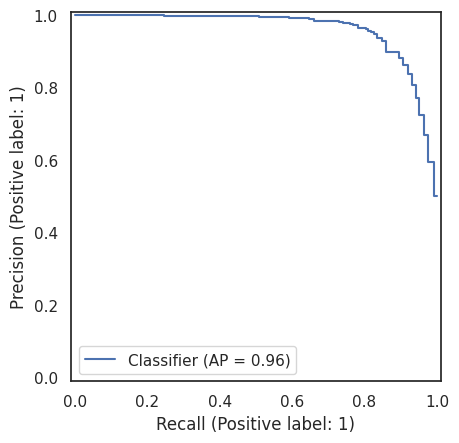

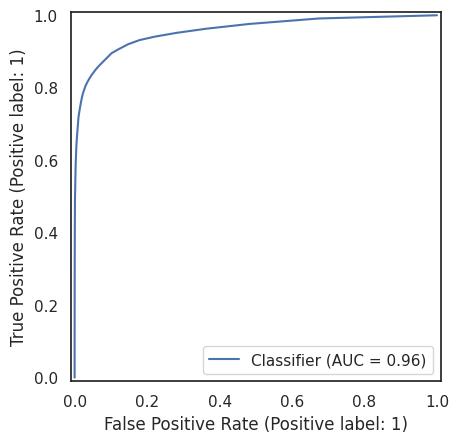

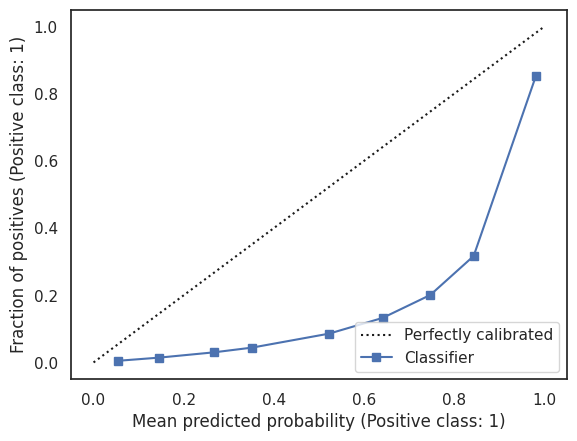

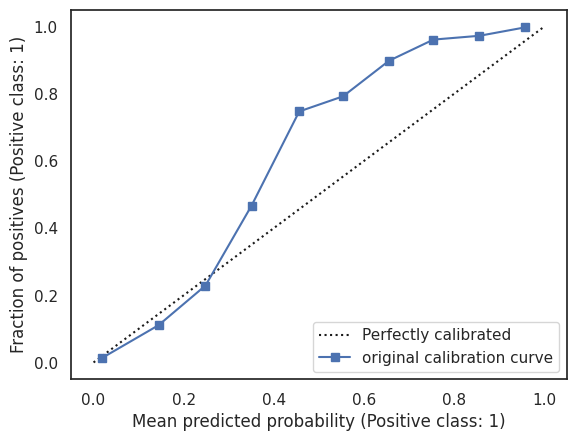

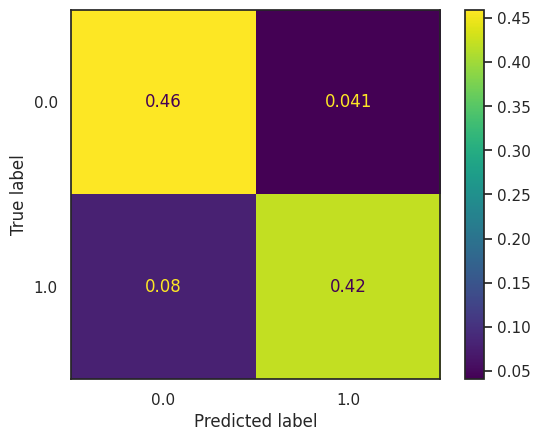

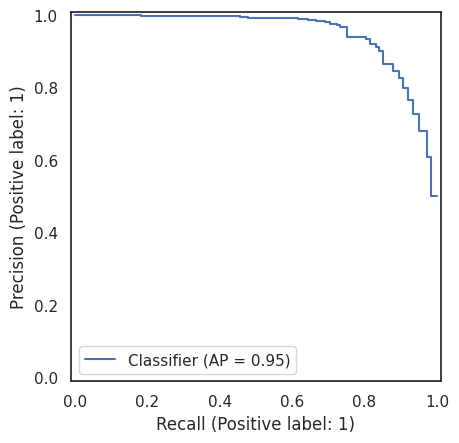

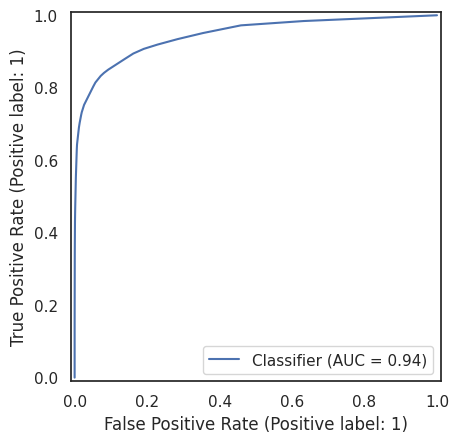

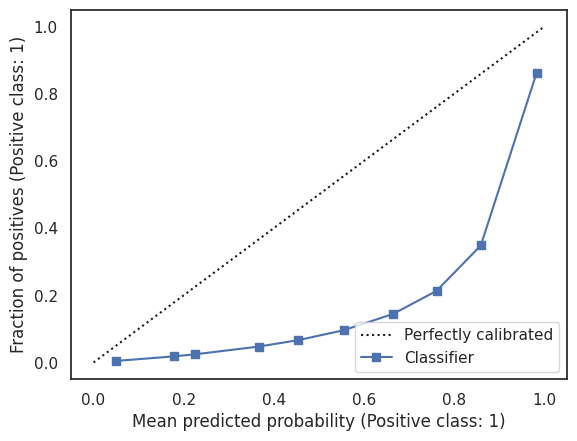

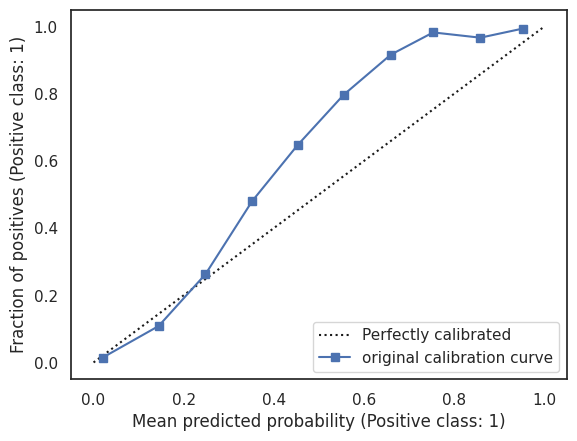

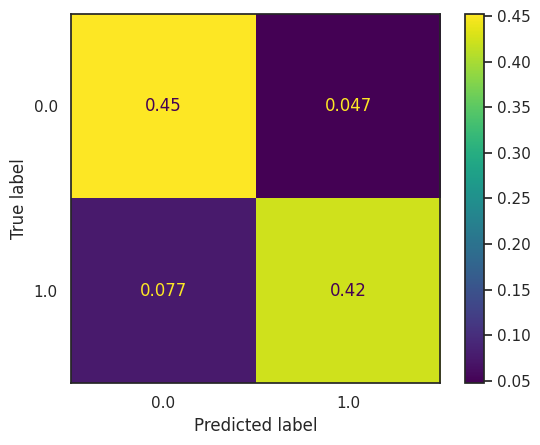

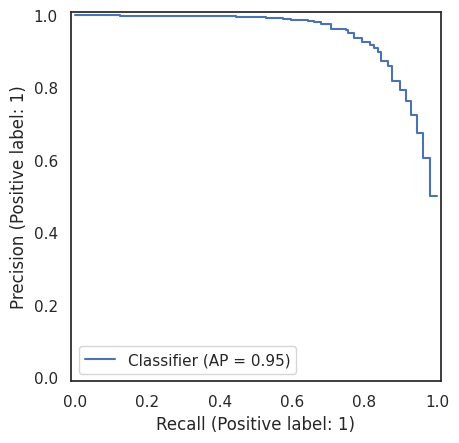

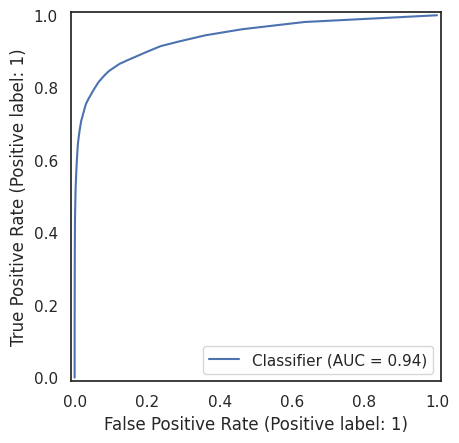

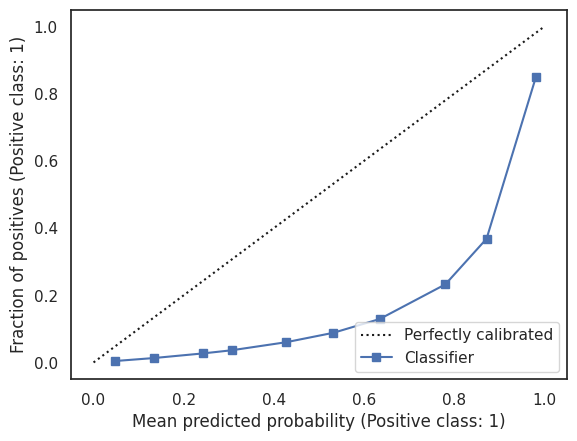

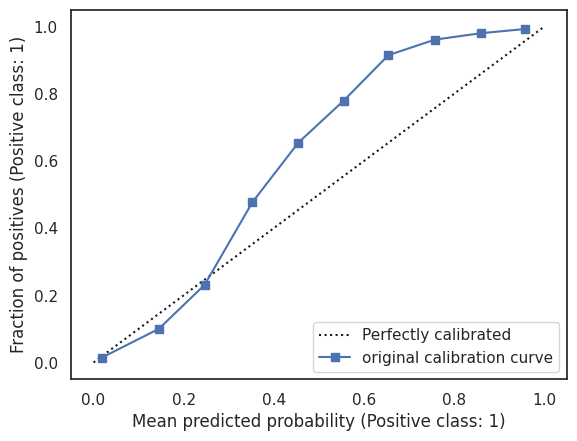

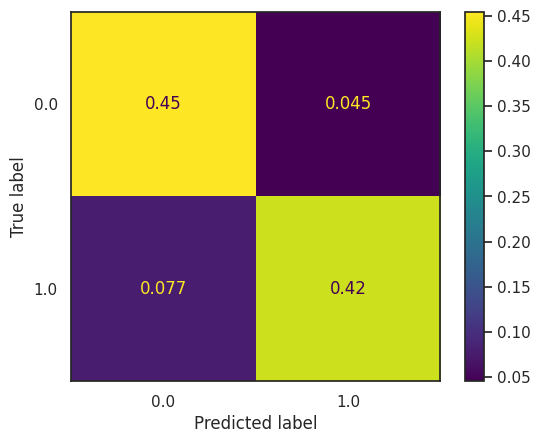

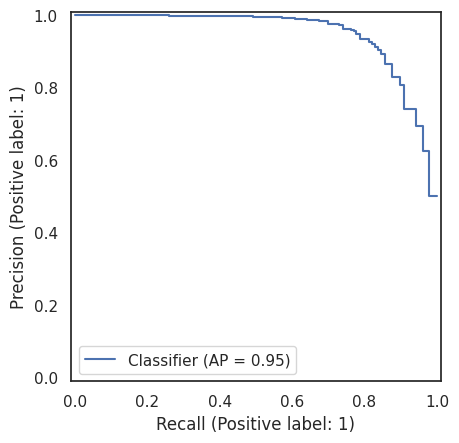

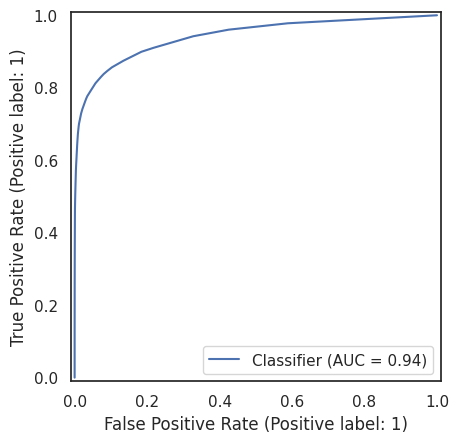

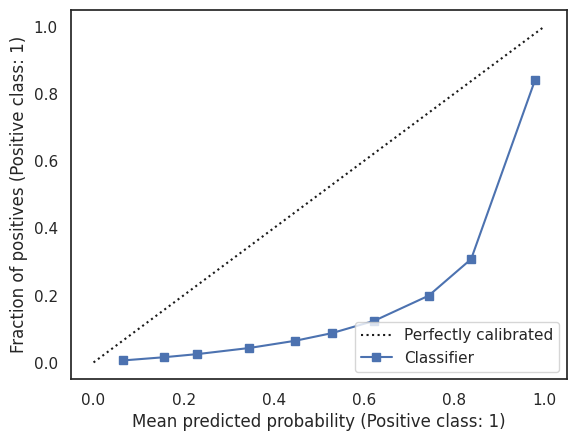

In [13]:
train_iterative_model(X=X, y=y, train_model_fn=train_random_random_forest, run_name="Random Forest")

In [ ]:
# train_iterative_model(X=X, y=y, train_model_fn=train_lightgbm, run_name="LightGBM")

In [ ]:
1/0

In [ ]:
X_corr: pd.DataFrame = preprocess_data_for_training().drop_nulls().drop("TransactionID").collect().to_pandas()

In [ ]:
import scipy
correlation: pd.DataFrame = X_corr.corr(method=scipy.spatial.distance.correlation, numeric_only=True)

In [ ]:
show_correlation(correlation, vmin=0, vmax=2)

In [ ]:
%%time

from dcor import CompileMode
import dcor
from functools import partial

correlation_fn = partial(dcor.distance_correlation, method="mergesort", compile_mode=CompileMode.COMPILE_CPU)

dcor_correlation: pd.DataFrame = X_corr.sample(1_000).corr(method=correlation_fn, numeric_only=True)
dcor_correlation

In [ ]:
show_correlation(dcor_correlation, vmin=0, vmax=1)

In [ ]:
# sns.pairplot(X[["C1", "C2", "C11", "C13", "C14"]])

In [ ]:
TARGET_COLUMN: str = "isFraud"
show_correlation_with_target(dcor_correlation, target_col=TARGET_COLUMN)

In [ ]:
threshold = 0.75  # Set your correlation threshold here

# Create a boolean mask where absolute correlation values are greater than the threshold
mask = pd.DataFrame(np.tril(dcor_correlation) > threshold, columns=dcor_correlation.columns)
mask_triangle: np.ndarray = np.tril(dcor_correlation)  > threshold

# Extract the correlated features using the mask
correlated_features = {}
for feature in dcor_correlation.columns:
    correlated_with = mask.index[mask[feature]].tolist()
    if correlated_with and len(correlated_with) > 1:
        for column_index in correlated_with:
            correlated_with_name: str = dcor_correlation.columns[column_index]
            if correlated_with_name != feature:
                correlated_features[feature] = correlated_with_name

print(correlated_features)